In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [15]:
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.molecule.obabel import obabel_to_eden, obabel_to_eden3d
from graphlearn import graphtools as gt
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = obabel_to_eden3d('AID2801_active.sdf', vector_label='vector_label')
graph = graphs.next()

We work on this graph


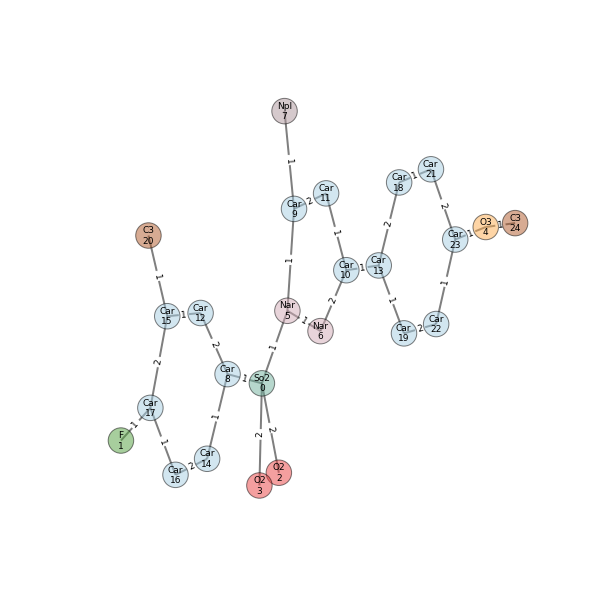

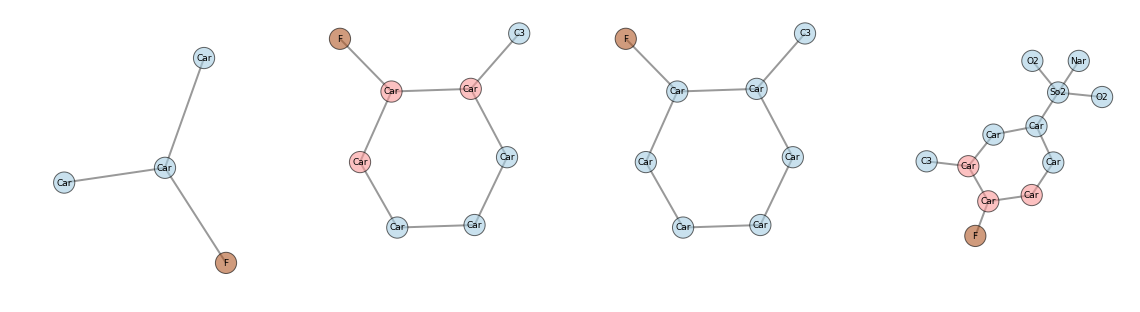

In [22]:
# Colour graphs
graphs = colorize([graph],output_attribute = 'color_level', labels = ['Car','So2','F', 'O2','O3','Nar','Npl','C3'])
graph = graphs.next()


print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)


def mark_and_draw(cip):
    graph=myutils.cip_to_graph(cip)
    myutils.draw_graph_set_graphlearn(graph, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.4, node_size=450)
    
radius_list=[0,2]
thickness_list=[2,4]
cip=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
mark_and_draw(cip)

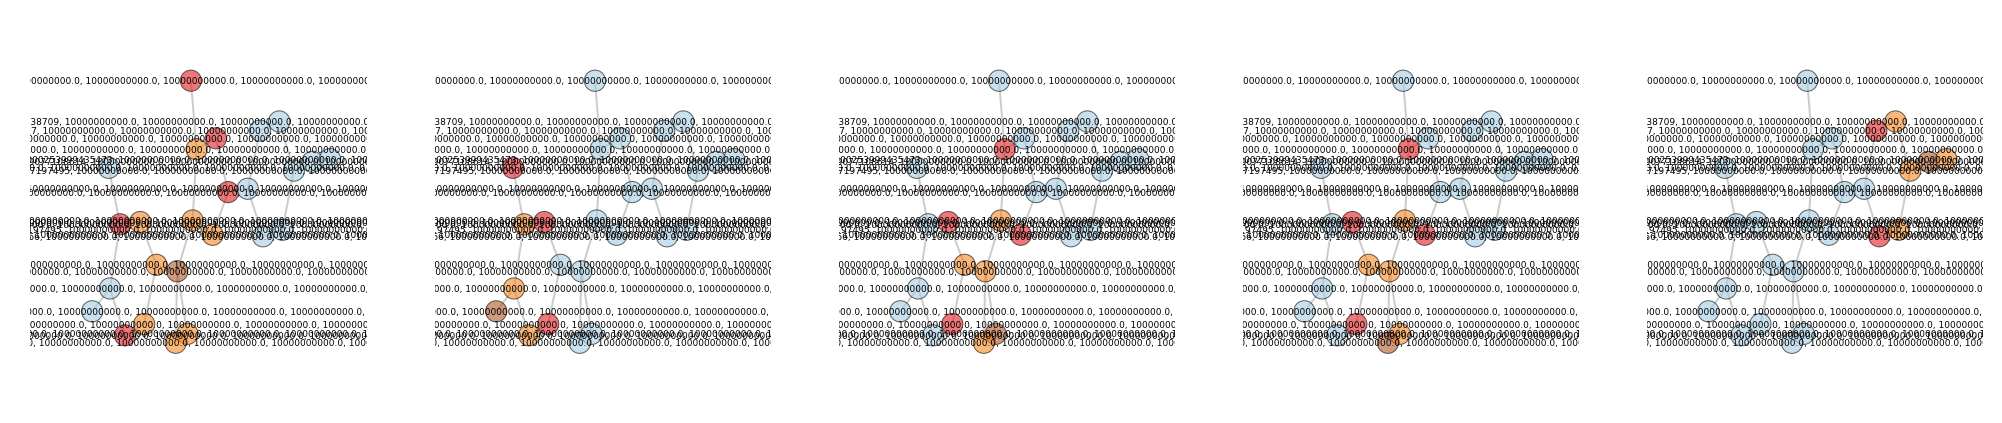

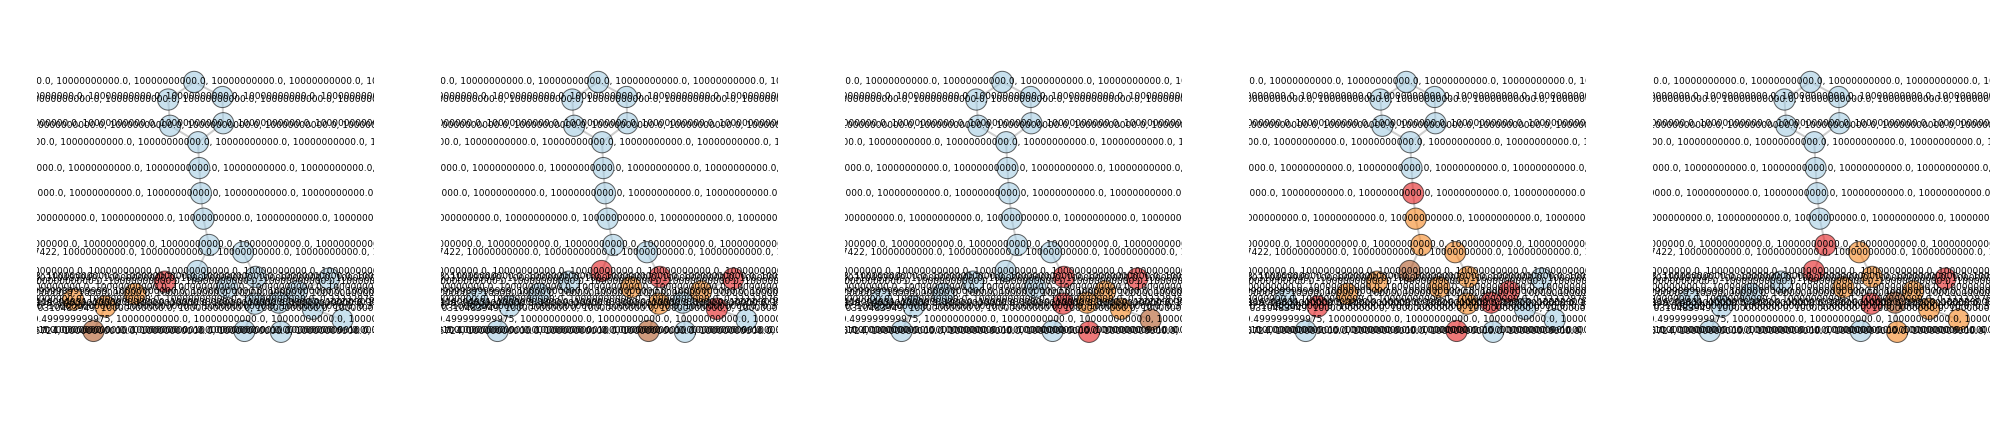

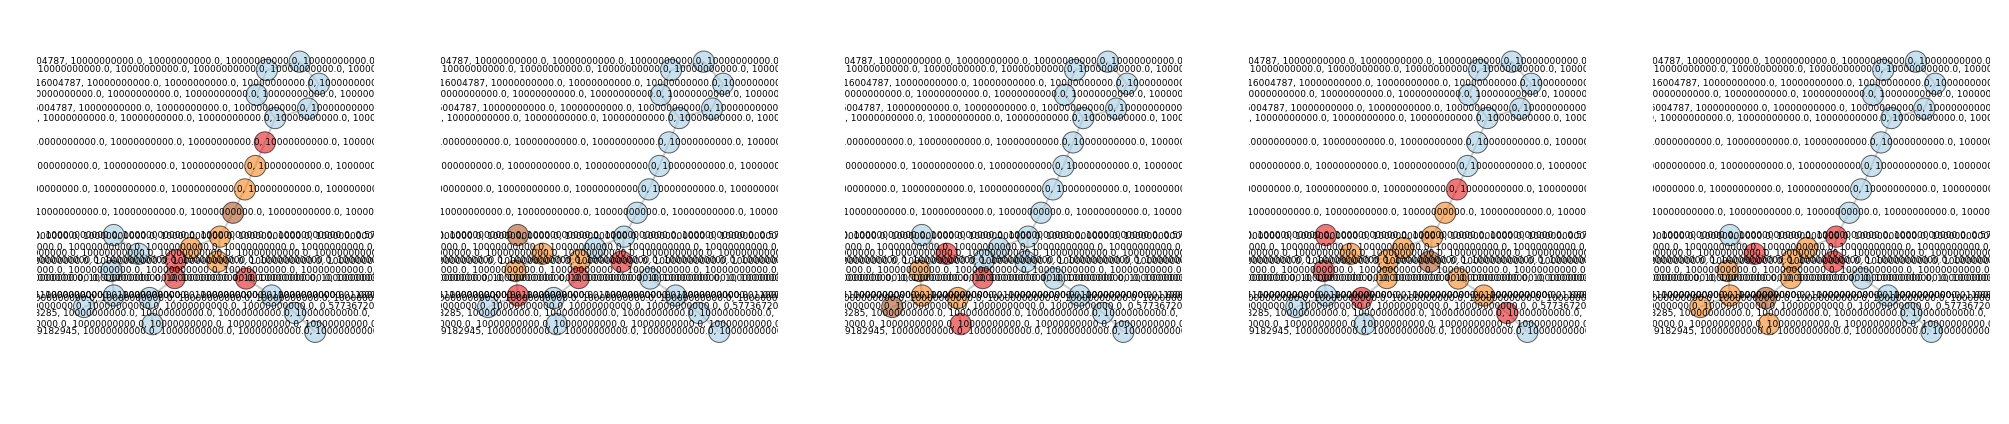

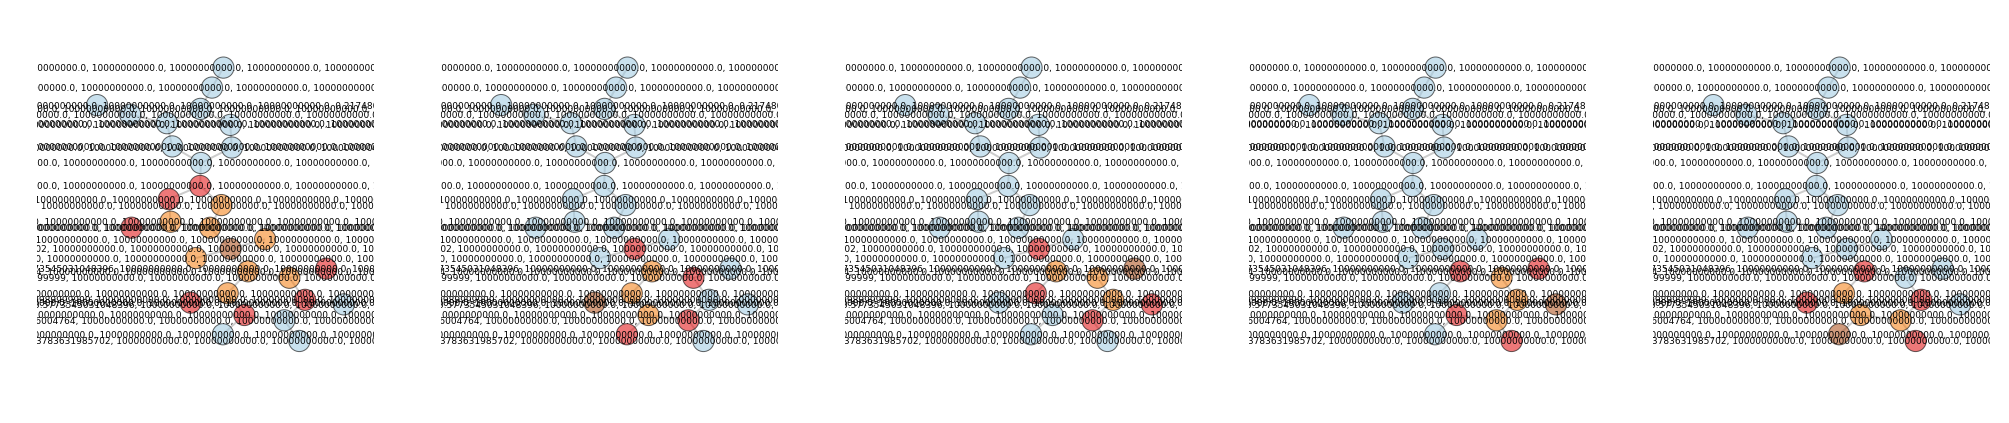

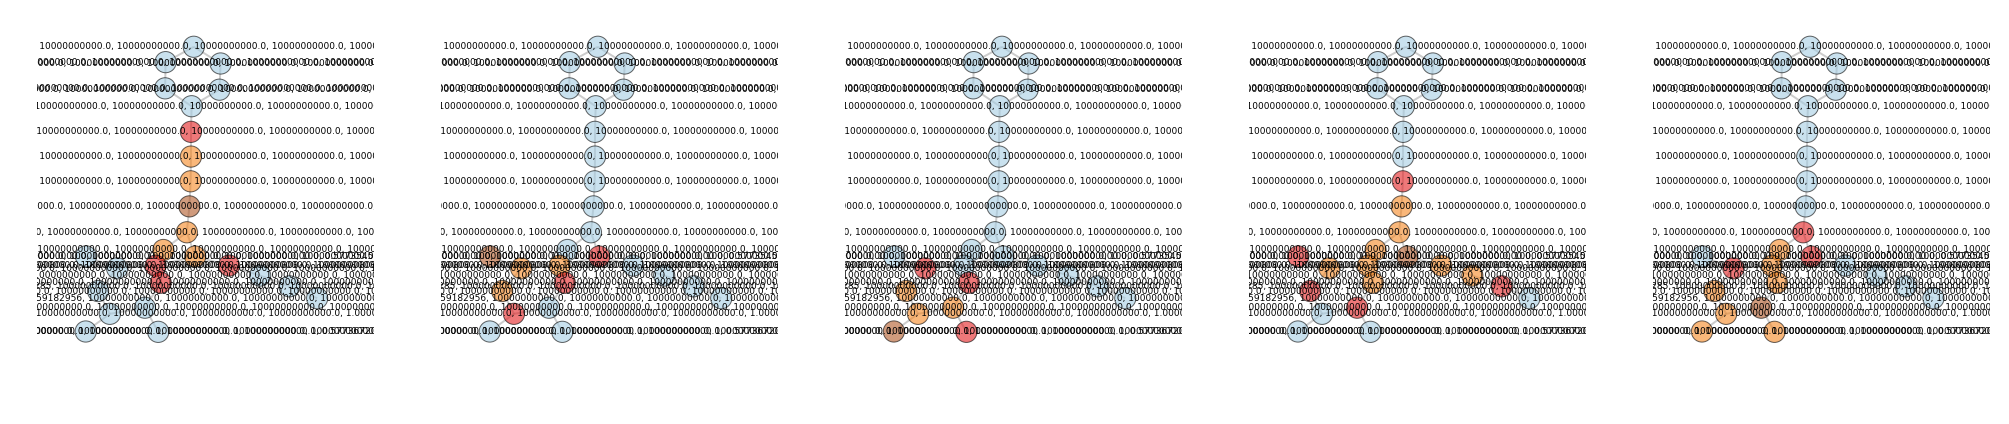

In [25]:
'''
demonstrating more extract core - 3d vector labels
'''
%matplotlib inline
import sys
sys.path.append('..')
import os
os.nice(20)
from eden.converter.molecule.obabel import obabel_to_eden3d
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import itertools

#get 5 graphs...
gr = obabel_to_eden3d( 'AID2801_active.sdf' )
gr, gr_ = itertools.tee(gr)
vectorizer = eg.Vectorizer(n=3)
vectorizer.fit(gr_)

for x in range (5):
    g=gr.next()
    # for each, pick 5 cores and extract cips 
    nice_graphs=[]
    for n in range(5):
        node=n
        a = gl.extract_core_and_interface(node, g, radius_list = [3],
                                          thickness_list = [1],
                                          vectorizer = vectorizer)
        # draw cip on the original graph and save in nice_graphs
        nice_graphs+=myutils.cip_to_graph(a, graphs = [g,g]) 
        
    # draw nice_graphs
    myutils.draw_graph_set_graphlearn(nice_graphs, 
                           n_graphs_per_line = 5, size = 7, 
                           colormap = 'Paired', invert_colormap = False, node_border = 1,
                           vertex_alpha = 0.6, edge_alpha = 0.2, node_size = 450)



In [29]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
import eden.graph as eg
from eden.converter.molecule.obabel import obabel_to_eden, obabel_to_eden3d
import itertools

# learn a grammar
training_graphs = obabel_to_eden3d('AID2801_active.sdf')
training_size = 300
training_graphs = itertools.islice(training_graphs,training_size)
training_graphs, training_graphs_ = itertools.tee(training_graphs)

vectorizer = eg.Vectorizer(n = 3)
vectorizer.fit(training_graphs_)

sampler = gl.GraphLearnSampler(radius_list = [0,1,2], thickness_list = [1,2], vectorizer = vectorizer)
sampler.fit(training_graphs, n_jobs = -1, core_interface_pair_remove_threshold = 3, interface_remove_threshold = 3)
sampler.save('tmp/demo_50.ge')

CPU times: user 2.91 s, sys: 815 ms, total: 3.72 s
Wall time: 13.5 s


interface: 215196


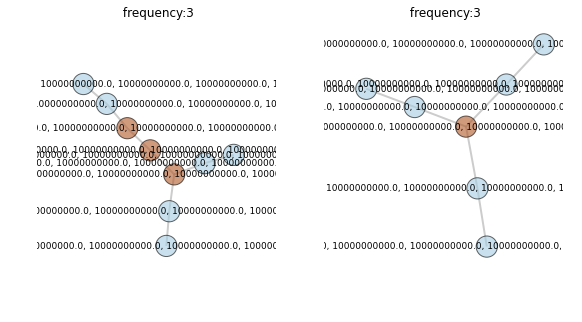

interface: 386594


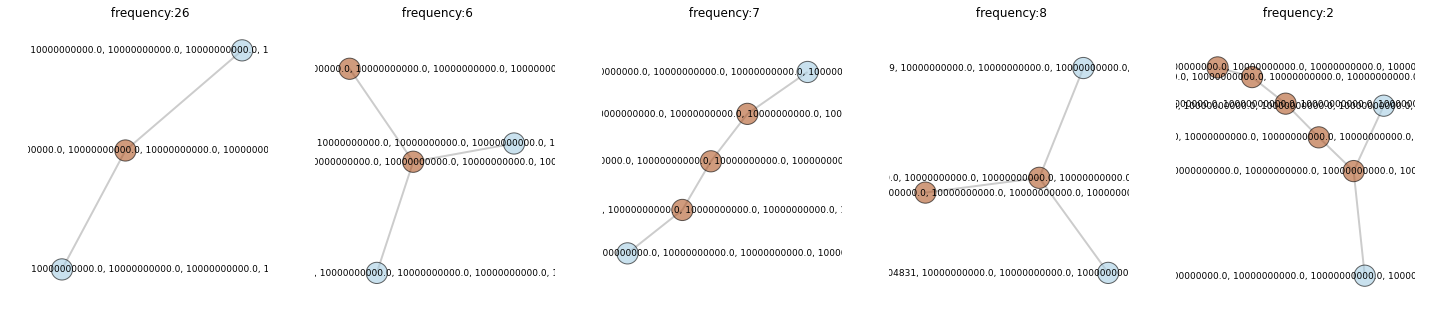

interface: 833573


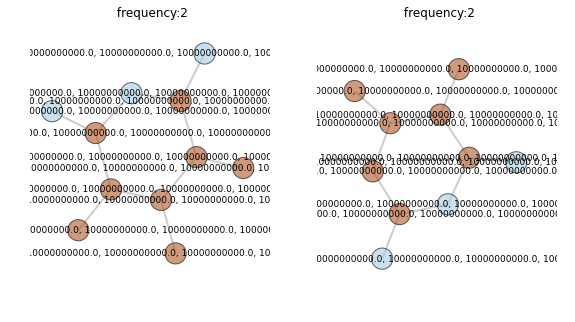

interface: 228400


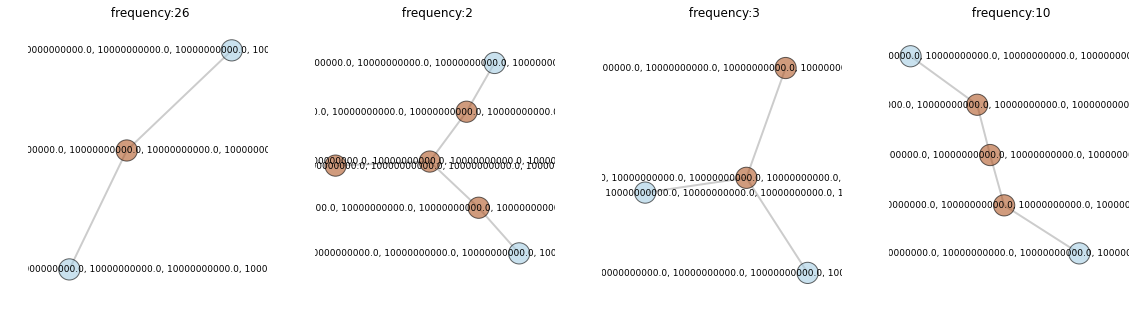

interface: 620599


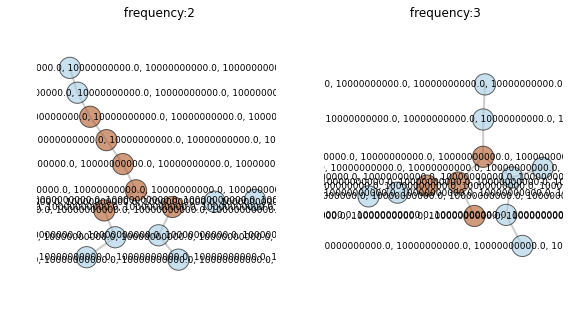

In [30]:
#draw production rules
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,
                     n_productions = 5,
                     n_graphs_per_line = 6, size = 5, 
                     colormap = 'Paired', invert_colormap = False, node_border = 1,
                     vertex_alpha = 0.6, edge_alpha = 0.2, node_size = 450)

how often do we see interfacehashes
# productions: 145
x = # interfaces (total: 51)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


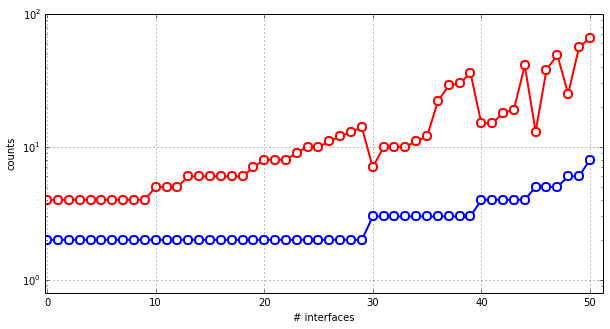

how often was this corehash seen?
x = # cores (total: 38)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


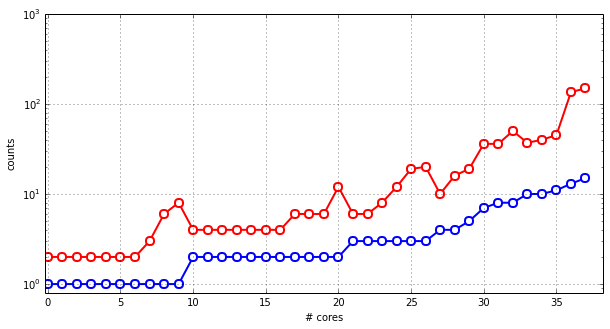

histogram
# productions: 145
distinct cores: 38 (seen on x axis)
interfaces with x many cores were observed y many times. 


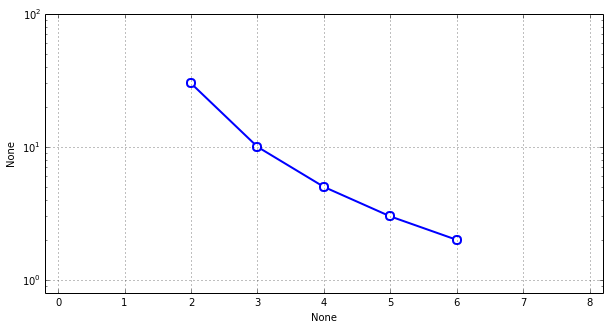

other histogram
how many cores exist with x many interfaces


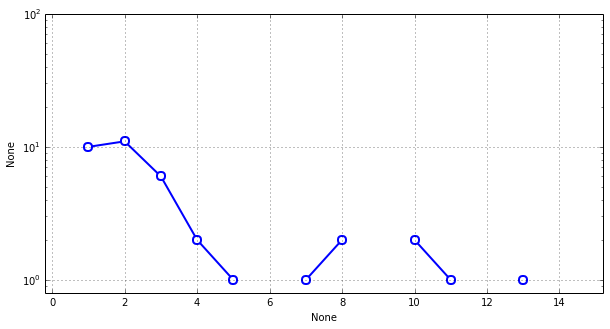

In [31]:
#grammar statistics
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar, size=(10,5))

In [36]:
%%time
'''
Graph sampling
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
from eden.converter.molecule.obabel import obabel_to_eden, obabel_to_eden3d
import itertools
import matplotlib.pyplot as plt
import graphlearn.utils.draw as myutils
import eden.graph as ge

sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo_50.ge')
graphs = obabel_to_eden('AID2801_active.sdf')
id_start=20
id_end=id_start+10
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=True,
                        n_samples=4,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        accept_annealing_factor=1.2,
                        probabilistic_core_choice=True,
                        burnout=1,
                        select_cip_max_tries=100,
                        keep_duplicates=False)

from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['C','O','N','P','Cl','Br','S','I'])
    myutils.draw_graph_set(path_graphs,
                           n_graphs_per_line=6, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.2, node_size=650,
                          headlinehook= myutils.get_score_of_graph
                          )

CPU times: user 382 ms, sys: 18.9 ms, total: 400 ms
Wall time: 425 ms


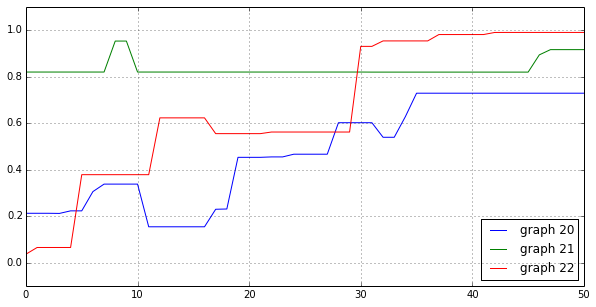

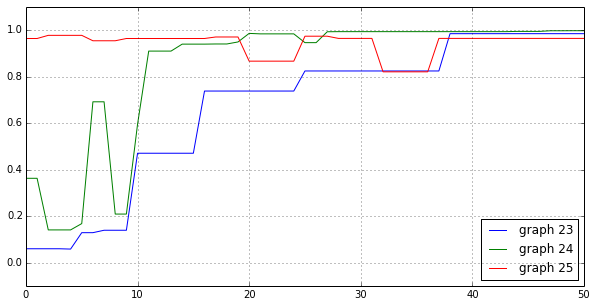

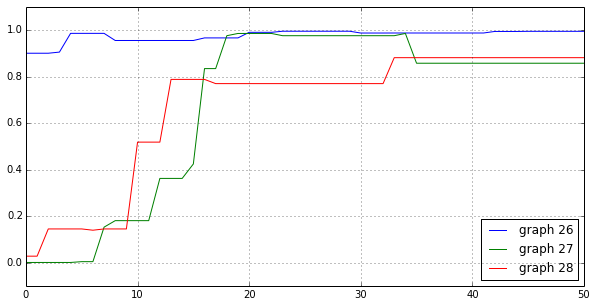

In [5]:
%matplotlib inline
from itertools import islice
import numpy as np
step=sampling_interval
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

We work on this graph


/Library/Python/2.7/site-packages/pygraphviz/agraph.py:1281: RuntimeWarning: Fontconfig warning: ignoring UTF-8: not a valid region tag

  warnings.warn("".join(errors),RuntimeWarning)


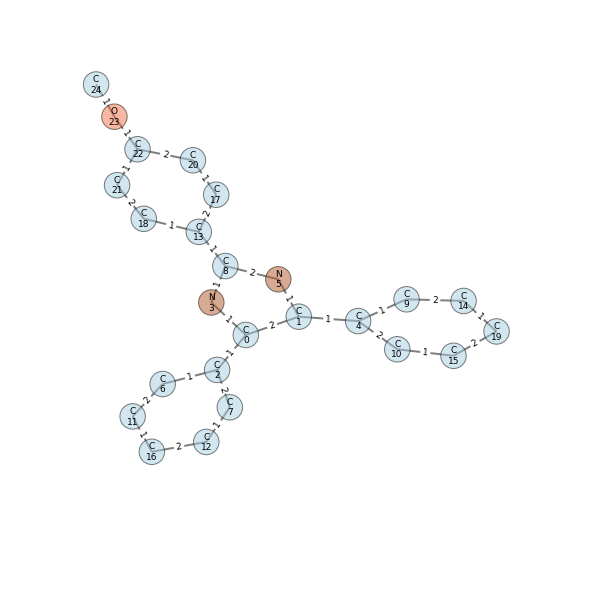

no filter


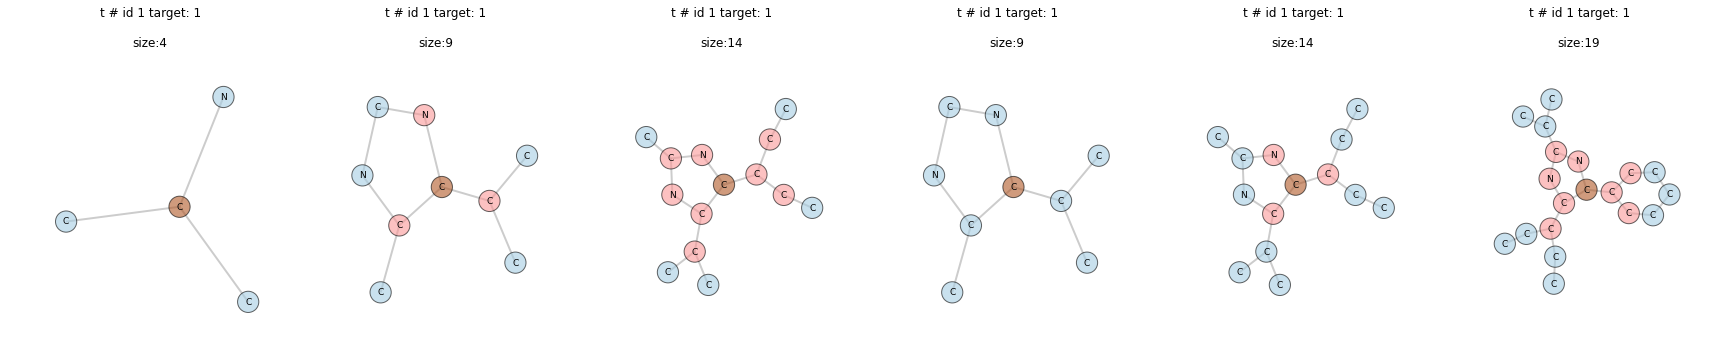

with filter: nothing should appear,,,
with filter but we chose node 2 as root


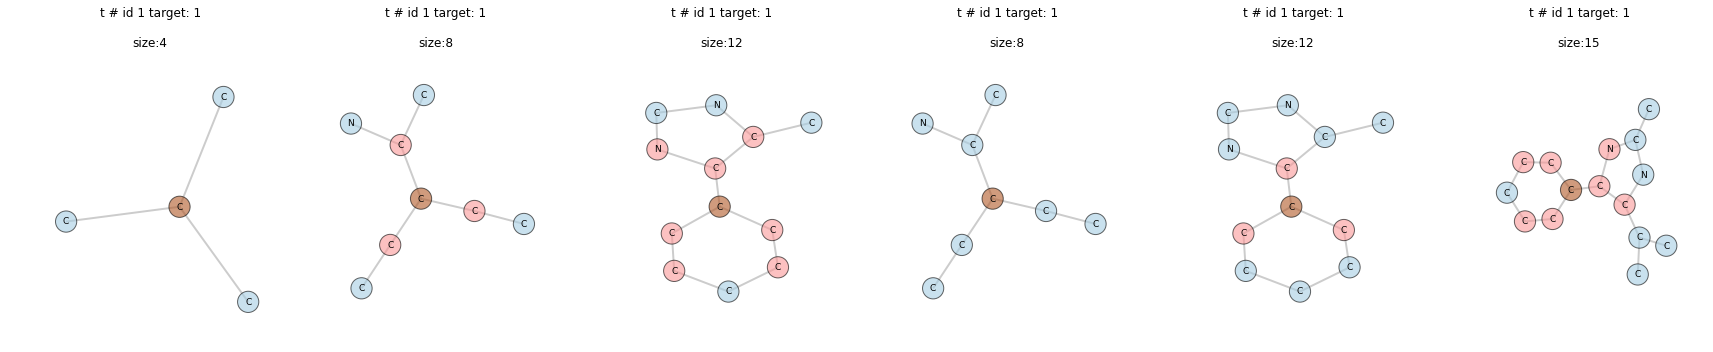

with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up


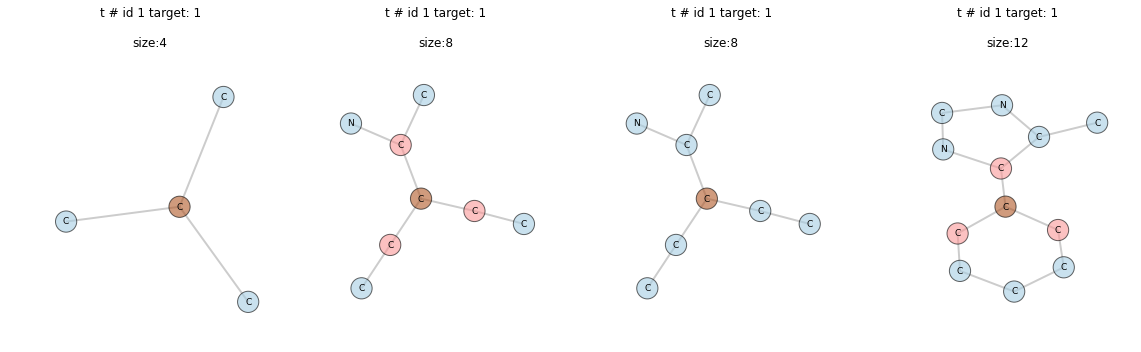

In [3]:
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl
import numpy as np

from eden.graph import Vectorizer
vectorizer=Vectorizer()

#get a graph
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graph=graphs.next()
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize  
graphs = colorize([graph],output_attribute = 'color_level', labels = ['C','O','N','P','Cl','Br','S'])    
graph=graphs.next()
print 'We work on this graph'
display.draw_graph(graph, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)


def mark_and_draw(cip):
    graph=myutils.cip_to_graph(cip)
    myutils.draw_graph_set_graphlearn(graph, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
radius_list=[0,1,2]
thickness_list=[1,2]
graph.node[1]['no_root']=True
#lets see.. without filter:
cip=gl.extract_core_and_interface(1,graph,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'no filter'
mark_and_draw(cip)


# lets do the same but with the filter
cip=gl.extract_core_and_interface(1,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter: nothing should appear,,,'
mark_and_draw(cip)

# filter is ignoring unfiltered things:
cip=gl.extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but we chose node 2 as root'
mark_and_draw(cip)


# no core attribute
graph.node[1]["not_in_core"]=True
graph.node[1].pop('no_root')
cip=gl.extract_core_and_interface(2,graph,filter=gt.filter,radius_list=radius_list,thickness_list=thickness_list,vectorizer=vectorizer)
print 'with filter but node "1" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up'
mark_and_draw(cip)